In [9]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
import shapely.geometry as sg
from datetime import datetime 
import seaborn as sns
import ast
import folium
import os
from tqdm import tqdm

In [10]:
df_tcmt = pd.read_csv('../Data/Tacheometry_raw.csv', index_col=0)

In [15]:
# get only the timeseries
df_tcmt_vals = df_tcmt.iloc[:,3:]

In [16]:
# replace every absolute value over 1000 with nan
df_tcmt_vals = df_tcmt_vals.mask((abs(df_tcmt_vals.values) > 1000))

In [17]:
df_tcmt_vals.values[abs(df_tcmt_vals.values) > 1000]

array([], dtype=float64)

In [18]:
# combine time series with object again
df_tcmt = pd.concat([df_tcmt.iloc[:,:3], df_tcmt_vals], axis=1)

In [19]:
# check if removal worked
df_tcmt.iloc[:,3:].values[abs(df_tcmt.iloc[:,3:].values) > 1000]

array([], dtype=float64)

In [20]:
pd.options.display.max_rows = 100
df_tcmt.insert(3, 'segment', df_tcmt.groupby('objectid').cumcount())

**To Do**
- Time series consistency
    - Take first day of the month as column
    - Average multiple measurements in one month
    - Interpolate values

- Add column 'segment' 1 to n
    - based on x and y coordinate
    - training will be done per objectid segment


In [21]:
def split_df_xyz(df, axis):
    
    # tell user the possible input if input is invalid
    if axis not in ['X', 'Y', 'Z']:
        print('Please enter "X", "Y", or "Z". Case sensitive.')
        return
    
    # store object ID and x/y coordinates
    df_axis = df[['objectid', 'X_coordinate', 'Y_coordinate', 'segment']]
    
    # take only columns for desired axis
    df_dates = df[[col for i, col in enumerate(df[df.columns[3:]]) if col[0] == axis]]
    
    # turn column names into dates
    df_dates.columns = df_dates.columns.str[1:]
    
    # return dataframe with object ID and x/y coordinate added
    return pd.concat([df_axis, df_dates], axis=1)

In [22]:
df_X = split_df_xyz(df_tcmt, 'X')
df_Y = split_df_xyz(df_tcmt, 'Y')
df_Z = split_df_xyz(df_tcmt, 'Z')

In [23]:
pd.options.mode.chained_assignment = None

def interpolate_df(df):
    
    # initiate new df
    df_new = df[['objectid', 'X_coordinate', 'Y_coordinate', 'segment']]
    
    # get all unique months in datetime first of that month
    # !! NOTE: Added + pd.offsets.MonthEnd() to fix removal of last month, but have not tested on this notebook yet!!
    test_dates = pd.date_range(start=pd.to_datetime(df.columns[4:])[0], end=pd.to_datetime(df.columns[4:])[-1] + pd.offsets.MonthEnd(), freq='M')-pd.offsets.MonthBegin(1)
    df_dates = pd.DataFrame()
    
    for month in test_dates:
                        
        # find columns of that month
        columns = [col for col in df.columns[4:] if pd.to_datetime(col).month == month.month \
                   and pd.to_datetime(col).year == month.year]
        
        # get mean value per row and add column of month with mean value
        df_dates[month] = df[columns].mean(axis=1)
        
    # fill first column with zero's if no measurement
    df_dates.iloc[:,0] = df_dates.iloc[:,0].fillna(0)
    
    # interpolate untill the last measurement
    df_dates = df_dates.interpolate(axis=1, limit_area='inside')
    
    return pd.concat([df_new, df_dates], axis=1)

In [24]:
df_Z = interpolate_df(df_Z)
df_Y = interpolate_df(df_Y)
df_X = interpolate_df(df_X)

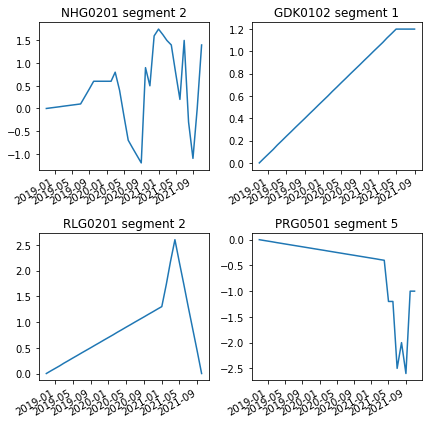

In [25]:
indices = np.random.randint(0, len(df_Y), 4)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6, 6))
axes = [ax1, ax2, ax3, ax4]

# plot four random time series
for j, i in enumerate(indices):
    df_X.iloc[i][4:].plot(ax=axes[j], title=f'{df_X.iloc[i][0]} segment {df_X.iloc[i][0][4]}')
fig.tight_layout()
plt.show()

In [26]:
df_Y.iloc[:,3:].values[abs(df_Y.iloc[:,3:].values) > 1000]

array([], dtype=float64)

In [27]:
df_X.index = df_X['objectid'].astype(str) + '_' + df_X['segment'].astype(str)
df_Y.index = df_Y['objectid'].astype(str) + '_' + df_Y['segment'].astype(str)
df_Z.index = df_Z['objectid'].astype(str) + '_' + df_Z['segment'].astype(str)

In [28]:
df_X.to_csv('../Data/TargetX.csv', index = True)
df_Y.to_csv('../Data/TargetY.csv', index = True)
df_X.to_csv('../Data/TargetZ.csv', index = True)